# Denoising experiments

## Import libraries

   Sample Index  EXG Channel 0  EXG Channel 1  EXG Channel 2  EXG Channel 3  \
0           6.0   -7041.917091  -13759.800942   21747.308582    1187.145852   
1           8.0   -7072.494277  -13787.718271   21716.709044    1181.513212   
2          10.0   -7130.854682  -13808.550097   21691.965662    1190.543317   
3          12.0   -7012.032808  -13750.793189   21754.952878    1183.614276   
4          14.0   -7152.669984  -13828.487853   21672.251424    1187.034093   

   EXG Channel 4  EXG Channel 5  EXG Channel 6  EXG Channel 7  EXG Channel 8  \
0   47436.302595   20674.156627   37196.968460   12375.780925   34990.560709   
1   47505.861223   20670.468589   37215.363945   12402.737129   35279.255841   
2   47273.268971   20624.491051   37097.637307   12291.581904   34970.958229   
3   47589.568506   20711.685206   37245.114117   12423.859528   35157.036502   
4   47320.453503   20619.596019   37100.699496   12290.196096   35155.114252   

   ...  Other.3  Other.4  Other.5  Other.6  

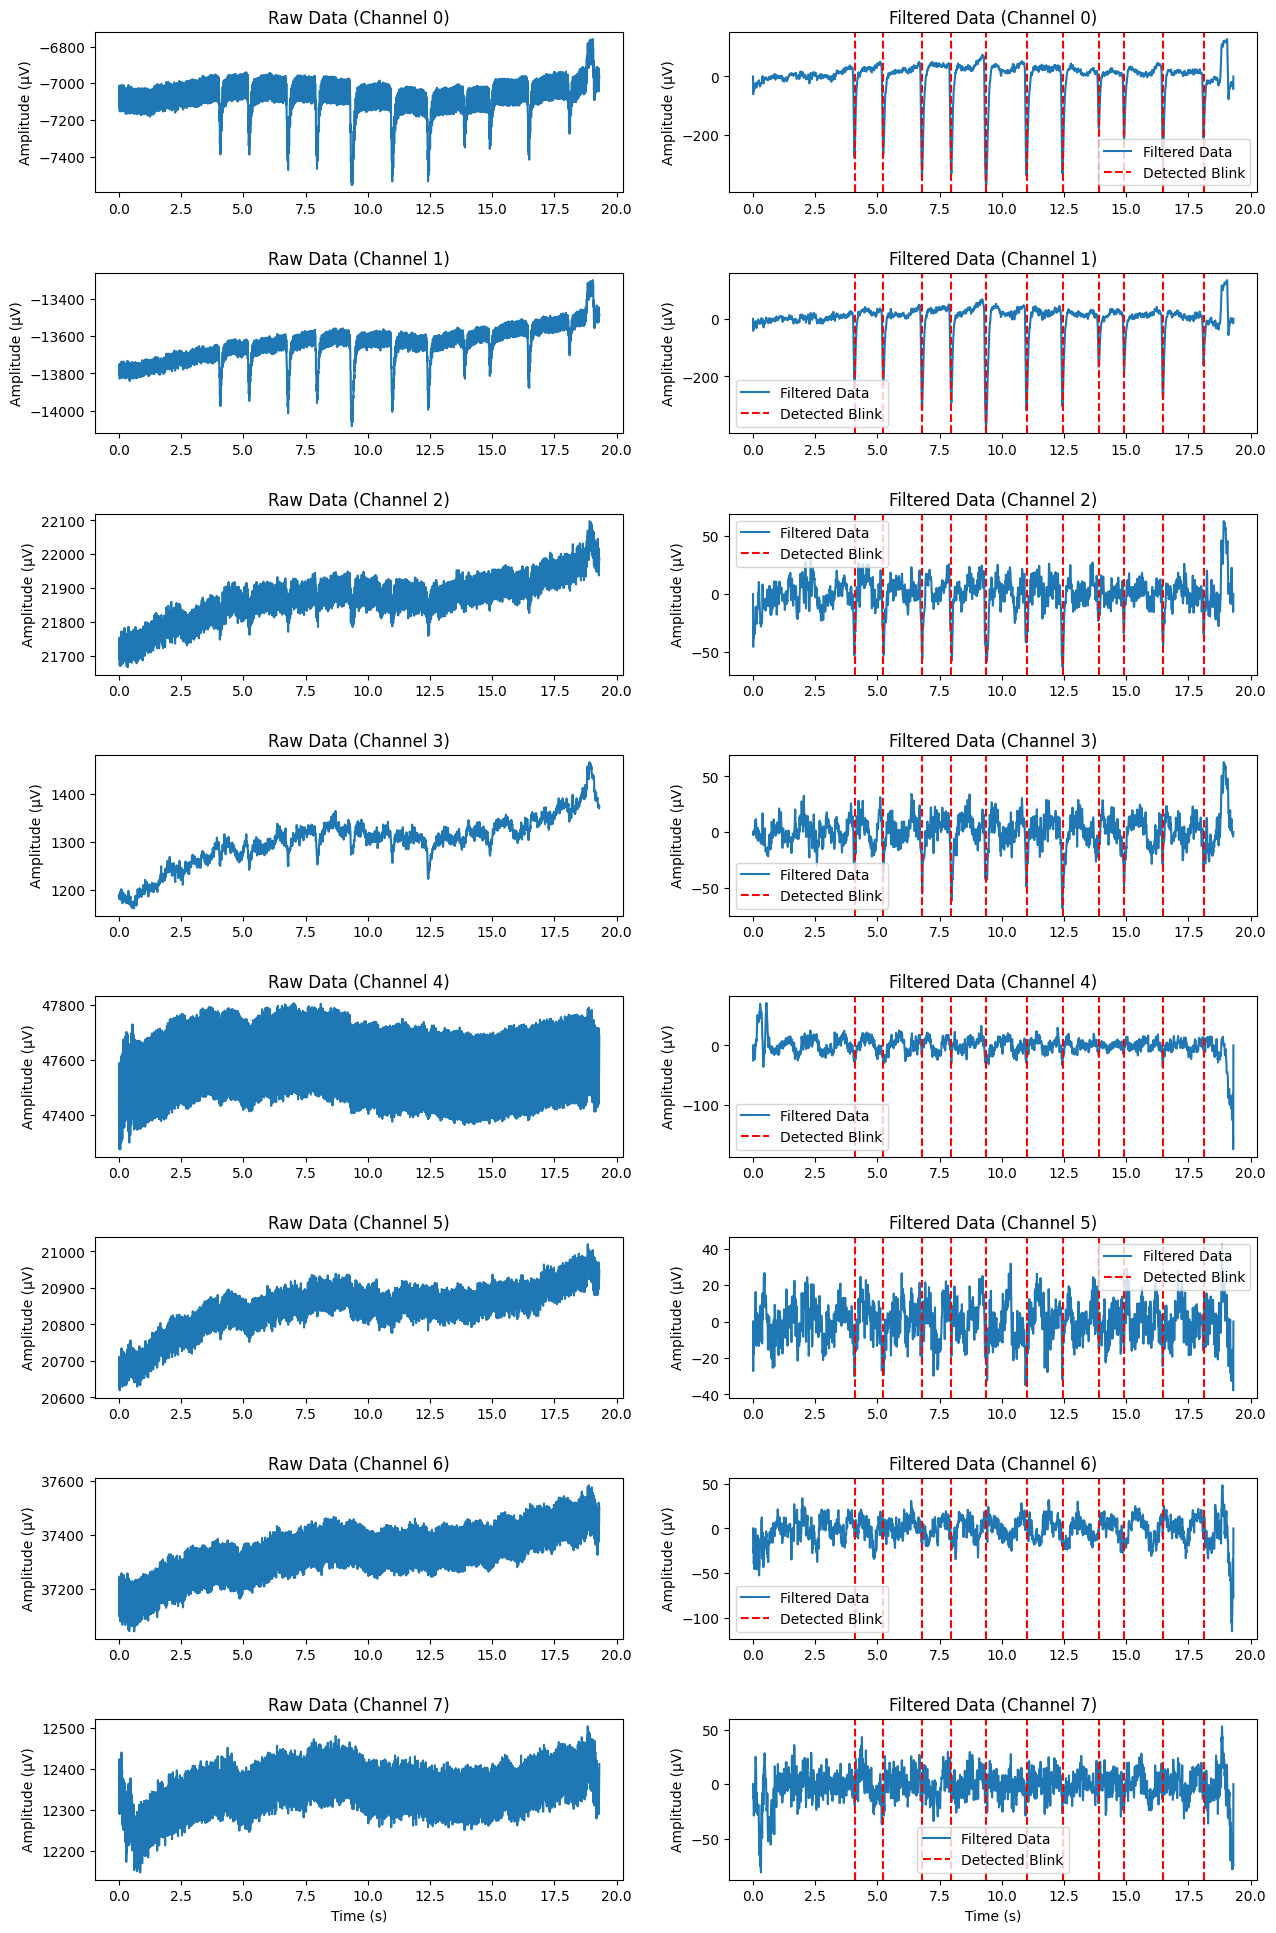

    sample  prev_event_id  event_id
0      510              0       998
1      655              0       998
2      849              0       998
3      996              0       998
4     1170              0       998
5     1374              0       998
6     1555              0       998
7     1738              0       998
8     1865              0       998
9     2060              0       998
10    2264              0       998


In [2]:
# Import necessary libraries
import mne
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
file_path = r"D:\Code\NEvol_git\Sandbox\Raw Data - 02052024\OpenBCISession_2024-02-09_11-10-01\OpenBCI-RAW-2024-02-09_11-31-53.txt"
df = pd.read_csv(file_path, comment='%')
df = df.rename(columns=lambda x: x.strip())
df = df[5:]  # Remove unnecessary header rows
df = df.reset_index(drop=True)  # Reset indices

# Display the first few rows to inspect
print(df.head())

# Step 2: Create RawArray for signal processing
# Selecting EEG data columns and setting sampling frequency
data_ica_df = df.iloc[:, 1:9]  # Assuming EEG data is in the first 8 columns after the index
sfreq = 125  # Sampling frequency in Hz
info = mne.create_info(ch_names=data_ica_df.columns.tolist(), sfreq=sfreq, ch_types='eeg')

# Create RawArray for EEG data
raw_eeg = mne.io.RawArray(data_ica_df.T.values * 1e-6, info)  # Convert µV to V

# Create EOG channel
eog_channel = data_ica_df.iloc[:, 0].values * 1e-6  # Convert µV to V
eog_info = mne.create_info(['EOG'], sfreq=sfreq, ch_types=['eog'])
eog_raw = mne.io.RawArray(eog_channel[None, :], eog_info)

# Merge EEG and EOG data before filtering
raw_combined = raw_eeg.add_channels([eog_raw])

# Apply bandpass filter to the combined data
raw_combined.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin')

# Step 3: Create EOG epochs to detect blinks
eog_epochs = mne.preprocessing.create_eog_epochs(raw_combined, ch_name='EOG')  # Specify the new EOG channel
eog_events = eog_epochs.events

# Print and create DataFrame for events
print(eog_events)
eog_events_df = pd.DataFrame(eog_events, columns=['sample', 'prev_event_id', 'event_id'])

# Step 4: Visualize raw and filtered data with detected blinks
fig, axs = plt.subplots(len(data_ica_df.columns), 2, figsize=(15, 3 * len(data_ica_df.columns)))

for i, channel in enumerate(data_ica_df.columns):
    # Raw signal display
    axs[i, 0].plot(df.index / sfreq, df[channel], label='Raw Data')
    axs[i, 0].set_title(f'Raw Data (Channel {i})')
    axs[i, 0].set_ylabel('Amplitude (µV)')
    if i == len(data_ica_df.columns) - 1:
        axs[i, 0].set_xlabel('Time (s)')

    # Filtered signal display
    axs[i, 1].plot(raw_combined.times, raw_combined.get_data(picks=[i])[0] * 1e6, label='Filtered Data')  # Convert back to µV
    
    # Mark detected blinks on the filtered data
    blink_samples = eog_events_df['sample'].values
    blink_times = blink_samples / sfreq
    for blink_time in blink_times:
        axs[i, 1].axvline(x=blink_time, color='r', linestyle='--', label='Detected Blink' if blink_time == blink_times[0] else "")
    
    axs[i, 1].set_title(f'Filtered Data (Channel {i})')
    axs[i, 1].set_ylabel('Amplitude (µV)')
    if i == len(data_ica_df.columns) - 1:
        axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].legend()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot with detected events
plt.show()

print(eog_events_df)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn

## Step 1: Data Analysis

In [2]:
df = pd.read_csv(r"D:\Code\NEvol_git\Sandbox\Raw Data - 02052024\OpenBCISession_2024-02-09_11-10-01\OpenBCI-RAW-2024-02-09_11-31-53.txt", comment='%')
df = df.rename(columns=lambda x: x.strip())
df = df[5:]
df.head()

Sample Index  EXG Channel 0  EXG Channel 1  EXG Channel 2  EXG Channel 3  \
5           6.0   -7041.917091  -13759.800942   21747.308582    1187.145852   
6           8.0   -7072.494277  -13787.718271   21716.709044    1181.513212   
7          10.0   -7130.854682  -13808.550097   21691.965662    1190.543317   
8          12.0   -7012.032808  -13750.793189   21754.952878    1183.614276   
9          14.0   -7152.669984  -13828.487853   21672.251424    1187.034093   

   EXG Channel 4  EXG Channel 5  EXG Channel 6  EXG Channel 7  EXG Channel 8  \
5   47436.302595   20674.156627   37196.968460   12375.780925   34990.560709   
6   47505.861223   20670.468589   37215.363945   12402.737129   35279.255841   
7   47273.268971   20624.491051   37097.637307   12291.581904   34970.958229   
8   47589.568506   20711.685206   37245.114117   12423.859528   35157.036502   
9   47320.453503   20619.596019   37100.699496   12290.196096   35155.114252   

   ...  Other.3  Other.4  Other.5  Other.6  Analog Channel 0  \
5  ...      0.0      0.0      0.0      0.0               0.0   
6  ...     15.5    120.0      2.0     96.0               0.0   
7  ...      0.0      0.0      0.0      0.0               0.0   
8  ...      0.0      0.0      0.0      0.0               0.0   
9  ...      0.0      0.0      0.0      0.0               0.0   

   Analog Channel 1  Analog Channel 2     Timestamp  Other.7  \
5               0.0               0.0  1.707475e+09      0.0   
6               0.0               0.0  1.707475e+09      0.0   
7               0.0               0.0  1.707475e+09      0.0   
8               0.0               0.0  1.707475e+09      0.0   
9               0.0               0.0  1.707475e+09      0.0   

      Timestamp (Formatted)  
5   2024-02-09 11:31:54.011  
6   2024-02-09 11:31:54.019  
7   2024-02-09 11:31:54.028  
8   2024-02-09 11:31:54.035  
9   2024-02-09 11:31:54.043  

[5 rows x 33 columns]

In [3]:
df.columns

Index(['Sample Index', 'EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2',
       'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6',
       'EXG Channel 7', 'EXG Channel 8', 'EXG Channel 9', 'EXG Channel 10',
       'EXG Channel 11', 'EXG Channel 12', 'EXG Channel 13', 'EXG Channel 14',
       'EXG Channel 15', 'Accel Channel 0', 'Accel Channel 1',
       'Accel Channel 2', 'Other', 'Other.1', 'Other.2', 'Other.3', 'Other.4',
       'Other.5', 'Other.6', 'Analog Channel 0', 'Analog Channel 1',
       'Analog Channel 2', 'Timestamp', 'Other.7', 'Timestamp (Formatted)'],
      dtype='object')

In [4]:
def plot_eeg(data, figsize=(20, 15), title=None):
    if isinstance(data, torch.Tensor):
        data = data.detach().numpy()

    num_plots = data.shape[1]

    fig, ax = plt.subplots(num_plots, 1, figsize=figsize)
    x = range(len(data))

    if data.ndim == 1:
        data = data[:, None]

    if num_plots == 1:
        ax = [ax]
        # data = data.reshape(1, -1)

    for i in range(num_plots):
        ax[i].plot(x, data[:, i], linewidth=0.5)
        ax[i].set_xlabel("Iter")
        ax[i].set_ylabel("Voltage ($\mu V$)")
        if title:
            ax[i].set_title(title)
        else:
            ax[i].set_title(df.columns[start_idx+i])

    plt.tight_layout()
    plt.show()

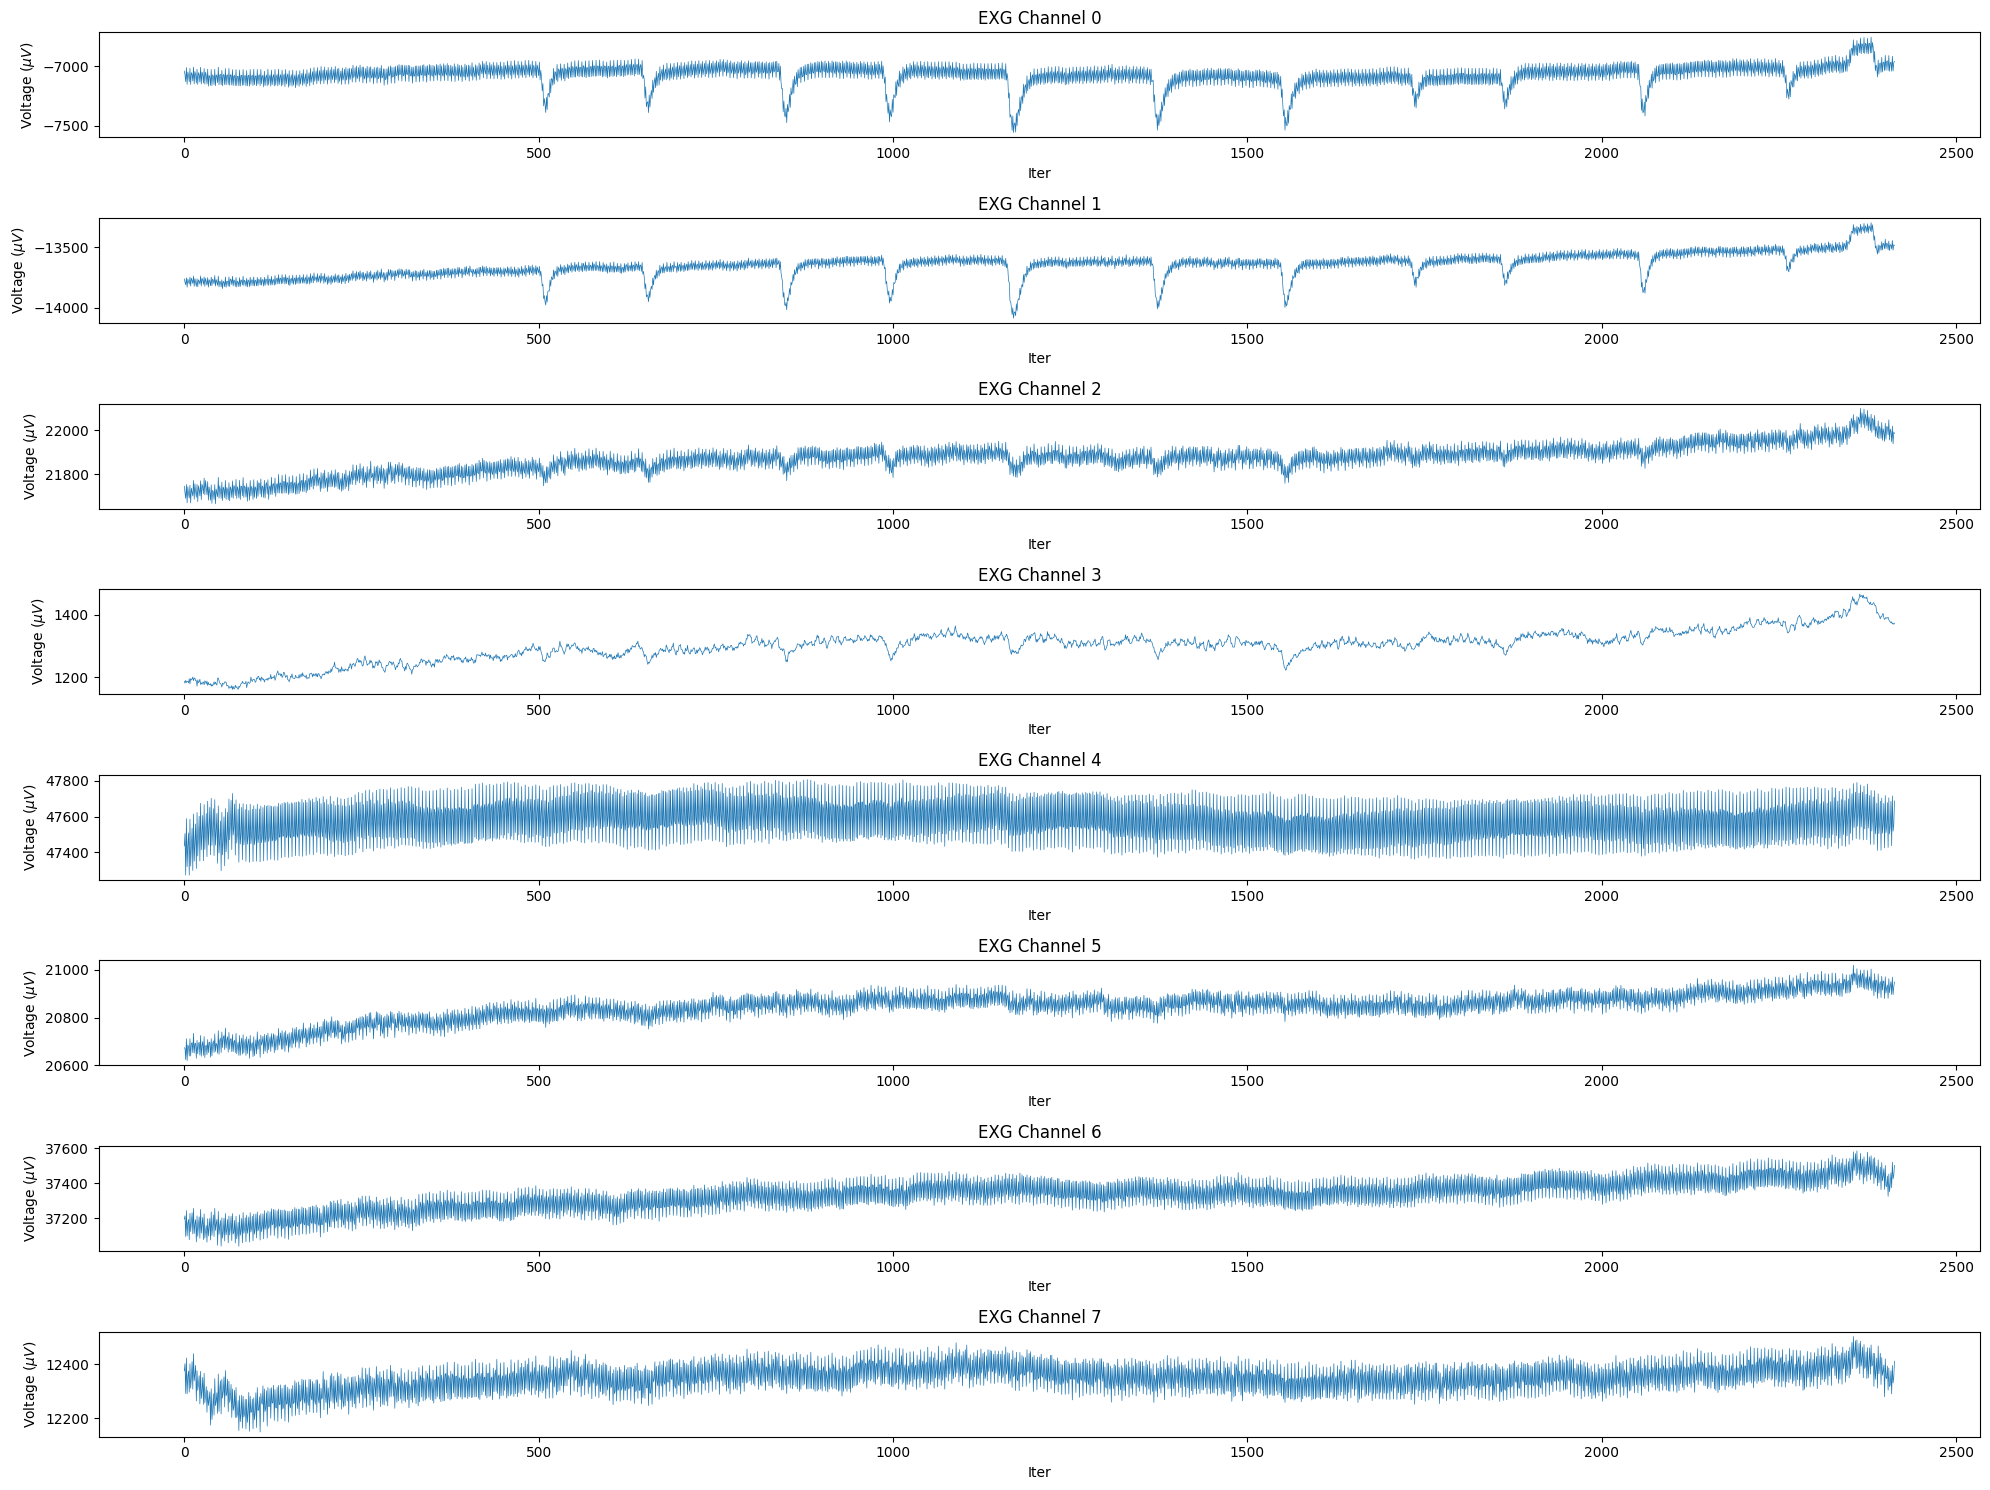

In [5]:
start_idx = 1
end_idx = start_idx + 8
raw_data = df.iloc[:, start_idx:end_idx].to_numpy()
plot_eeg(raw_data)

## 1. 1D Convolutions

In [6]:
data_conv_df = df.iloc[:, 1]
data_conv_df.head()

5   -7041.917091
6   -7072.494277
7   -7130.854682
8   -7012.032808
9   -7152.669984
Name: EXG Channel 0, dtype: float64

In [7]:
data_conv = torch.tensor(data_conv_df.to_numpy(), dtype=torch.float32).view(1, 1, -1)

In [8]:
class ConvolutionNoiseReductor(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(ConvolutionNoiseReductor, self).__init__()
        self.conv = nn.Conv1d(1, 1, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.conv(x)
        return x

In [9]:
model = ConvolutionNoiseReductor(kernel_size=256, stride=16)

result = model(data_conv)

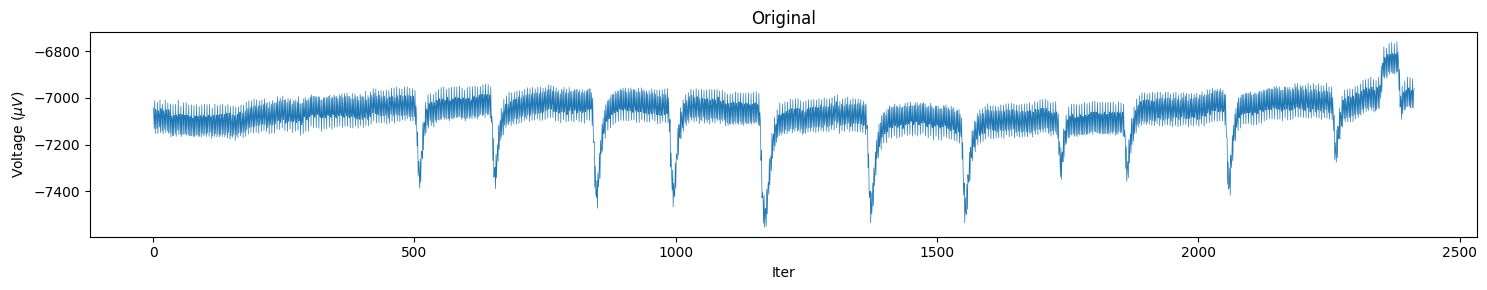

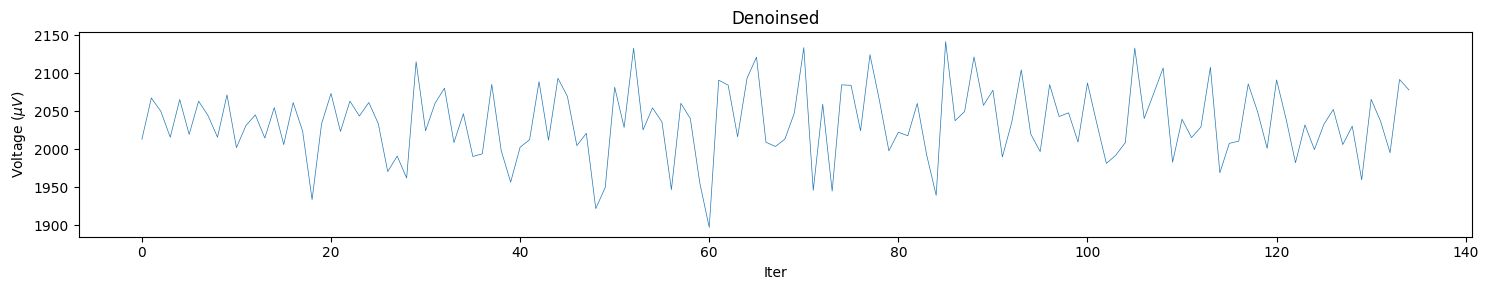

In [10]:
plot_eeg(df["EXG Channel 0"].to_numpy()[..., np.newaxis], figsize=(15, 3), title="Original")
plot_eeg(result[0, :, :].T, figsize=(15, 3), title="Denoinsed")

**Convolutions ❌** \\
One major flaw of using convolutions for EEG signal denoising is that the values have a very large shift after applying the convolution.

## 2. ICA

In [11]:
!pip install -q mne


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import mne
from mne.preprocessing import ICA

In [13]:
data_ica_df = df.iloc[:, 1:9]
data_ica_df.head()

EXG Channel 0  EXG Channel 1  EXG Channel 2  EXG Channel 3  EXG Channel 4  \
5   -7041.917091  -13759.800942   21747.308582    1187.145852   47436.302595   
6   -7072.494277  -13787.718271   21716.709044    1181.513212   47505.861223   
7   -7130.854682  -13808.550097   21691.965662    1190.543317   47273.268971   
8   -7012.032808  -13750.793189   21754.952878    1183.614276   47589.568506   
9   -7152.669984  -13828.487853   21672.251424    1187.034093   47320.453503   

   EXG Channel 5  EXG Channel 6  EXG Channel 7  
5   20674.156627   37196.968460   12375.780925  
6   20670.468589   37215.363945   12402.737129  
7   20624.491051   37097.637307   12291.581904  
8   20711.685206   37245.114117   12423.859528  
9   20619.596019   37100.699496   12290.196096

In [14]:
sfreq = 125
info = mne.create_info(ch_names=data_ica_df.columns.tolist(), sfreq=sfreq, ch_types='eeg')

raw = mne.io.RawArray(data_ica_df.T.values, info)

#ica = ICA(n_components=None, random_state=42, max_iter=800)
ica = ICA(n_components=0.95, random_state=42, max_iter=800)

#raw.filter(l_freq=1.0, h_freq=None)
raw.filter(l_freq=1.0, h_freq=40)
ica.fit(raw)

Creating RawArray with float64 data, n_channels=8, n_times=2414
    Range : 0 ... 2413 =      0.000 ...    19.304 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 413 samples (3.304 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 3 components
Fitting ICA took 1.7s.


<ICA | raw data decomposition, method: fastica (fit in 11 iterations on 2414 samples), 3 ICA components (8 PCA components available), channel types: eeg, no sources marked for exclusion>

In [15]:
ica.apply(raw)
denoised_df = pd.DataFrame(raw.get_data().T, columns=data_ica_df.columns.tolist())
denoised_df.head()

Applying ICA to Raw instance
    Transforming to ICA space (3 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


EXG Channel 0  EXG Channel 1  EXG Channel 2  EXG Channel 3  EXG Channel 4  \
0  -2.022153e-12   7.069738e-13  -1.024736e-12   8.092527e-14   7.728306e-12   
1  -6.080439e+01  -4.176556e+01  -4.557597e+01  -2.764327e+00  -2.579962e+01   
2  -3.184793e+01  -2.142974e+01  -2.612443e+01  -7.652245e-01  -1.167535e+01   
3  -3.261333e+01  -2.315852e+01  -2.769458e+01   7.391212e-01  -8.053657e+00   
4  -4.997331e+01  -3.480584e+01  -3.815961e+01  -1.382825e+00  -1.790793e+01   

   EXG Channel 5  EXG Channel 6  EXG Channel 7  
0   5.853729e-12   8.183007e-12   3.947956e-12  
1  -2.716901e+01  -2.681377e+01  -1.288942e+01  
2  -9.749875e+00  -2.208255e+01  -1.212742e+01  
3  -8.706252e+00  -2.824713e+01  -1.802100e+01  
4  -1.769363e+01  -3.946156e+01  -2.894343e+01

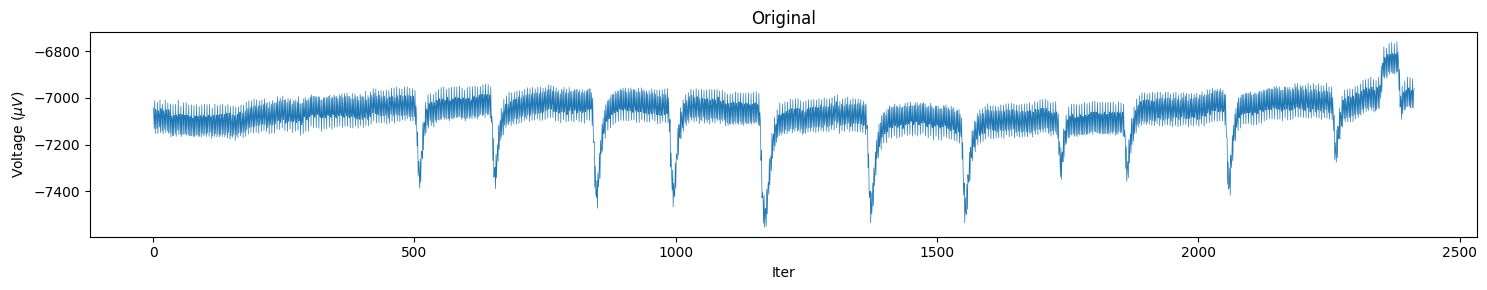

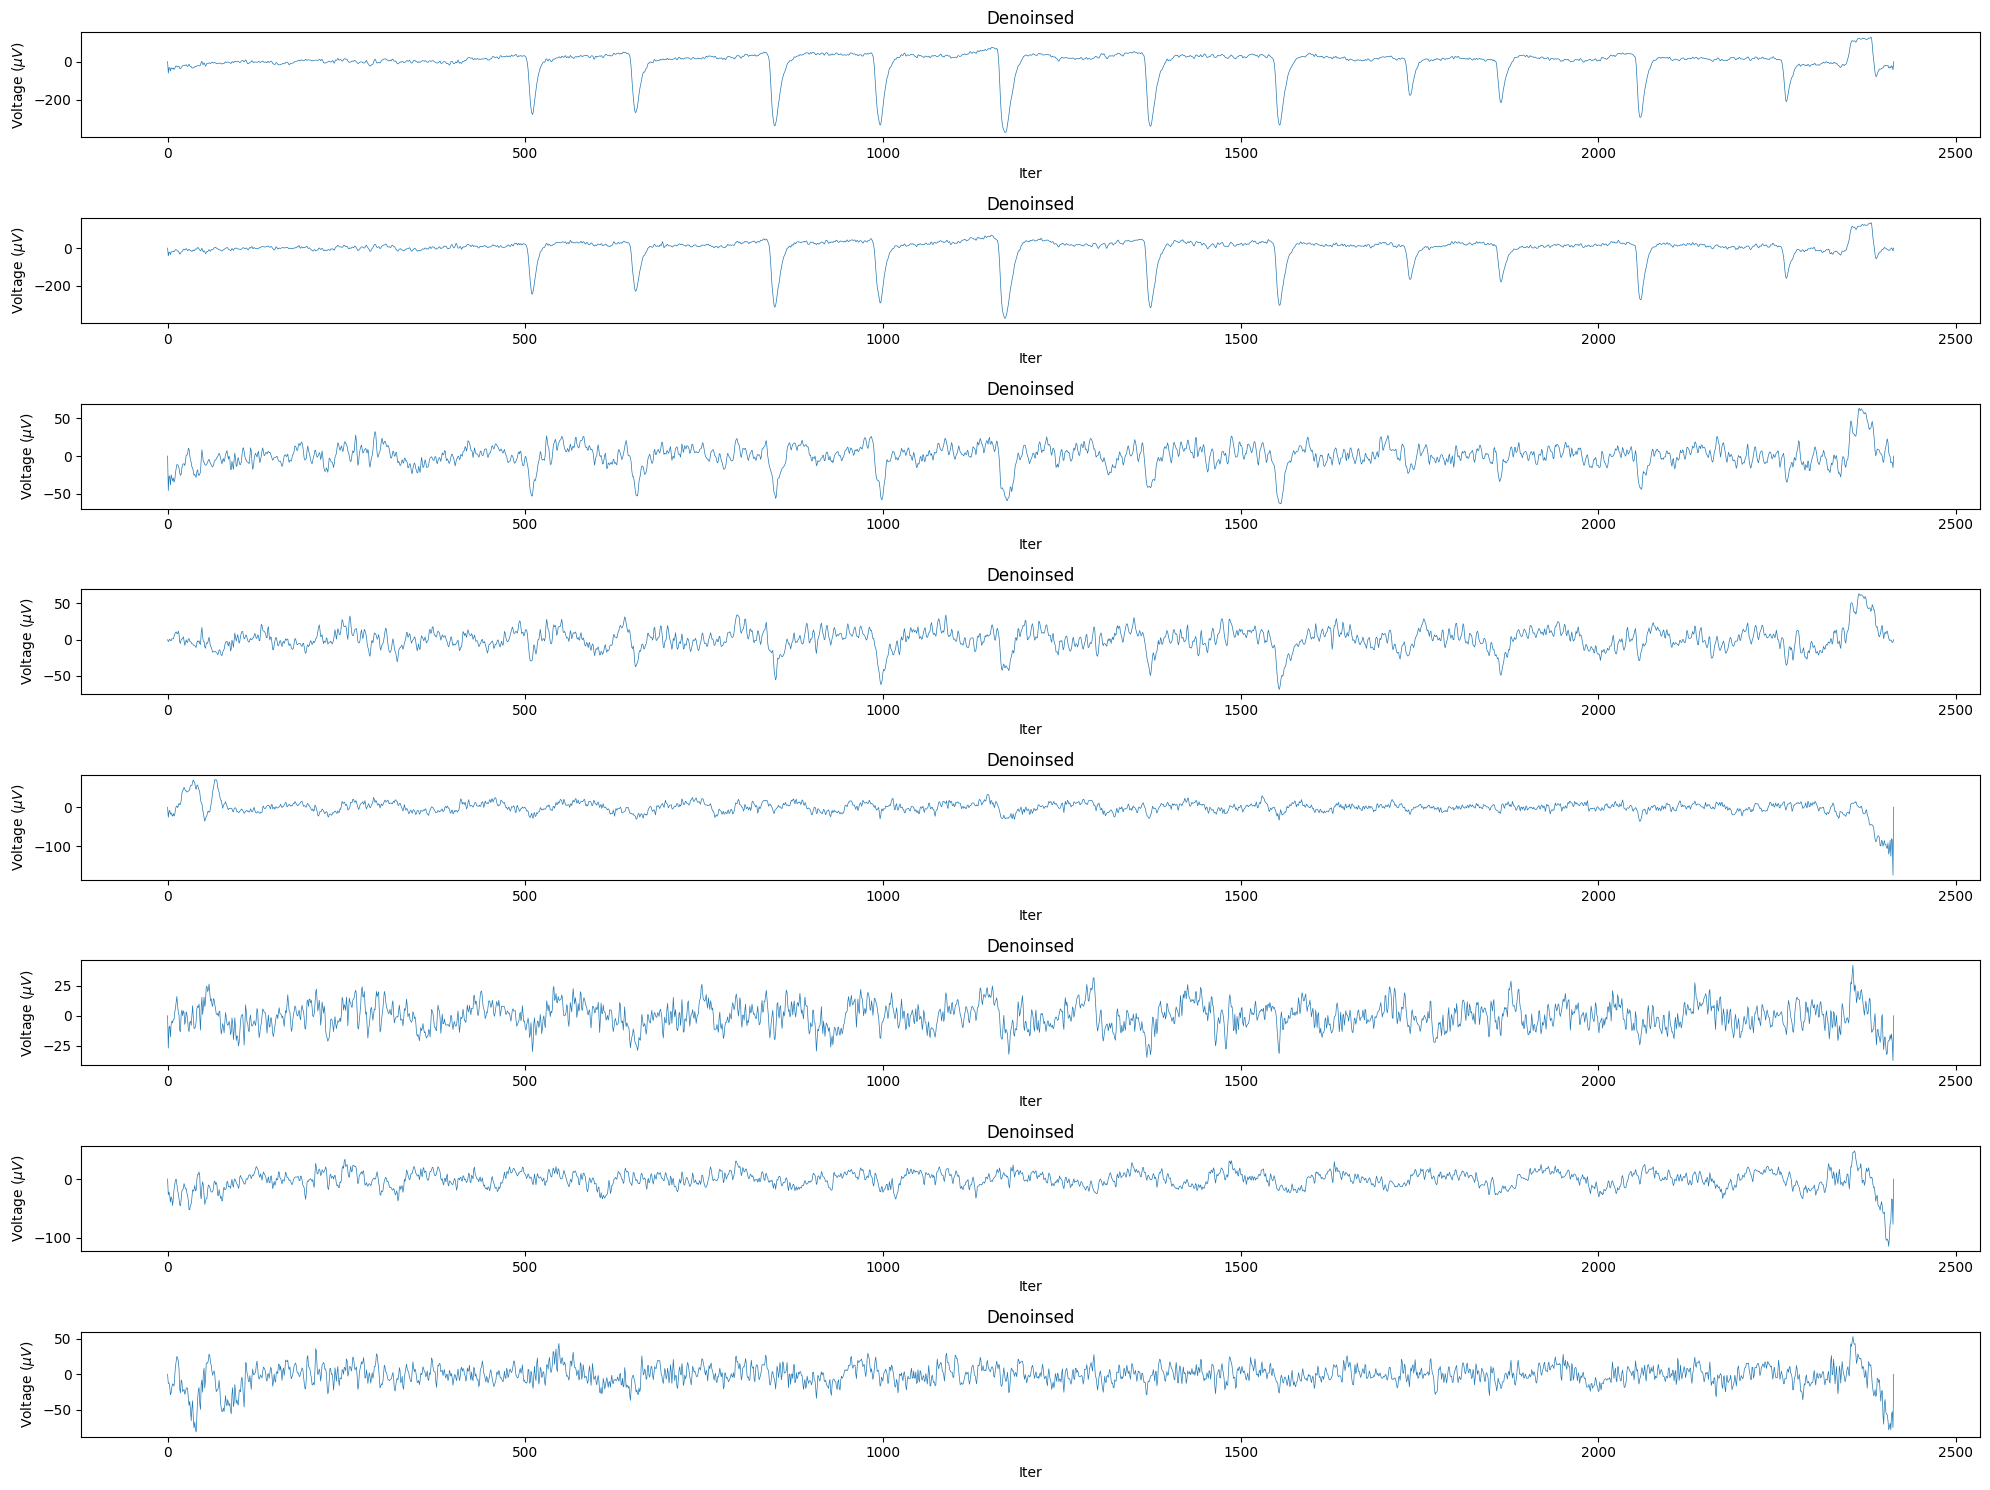

In [16]:
plot_eeg(df["EXG Channel 0"].to_numpy()[..., np.newaxis], figsize=(15, 3), title="Original")
plot_eeg(denoised_df.to_numpy(), title="Denoinsed")

In [17]:
#filtering experiment from below

In [18]:
denoised_df

EXG Channel 0  EXG Channel 1  EXG Channel 2  EXG Channel 3  \
0     -2.022153e-12   7.069738e-13  -1.024736e-12   8.092527e-14   
1     -6.080439e+01  -4.176556e+01  -4.557597e+01  -2.764327e+00   
2     -3.184793e+01  -2.142974e+01  -2.612443e+01  -7.652245e-01   
3     -3.261333e+01  -2.315852e+01  -2.769458e+01   7.391212e-01   
4     -4.997331e+01  -3.480584e+01  -3.815961e+01  -1.382825e+00   
...             ...            ...            ...            ...   
2409  -3.277956e+01  -4.003665e+00  -9.136105e+00  -2.734889e-01   
2410  -2.217153e+01   1.074096e+00  -7.839344e+00  -1.826173e+00   
2411  -2.455847e+01  -3.873227e+00  -8.652809e+00  -4.089382e+00   
2412  -4.345001e+01  -1.542014e+01  -1.544825e+01  -2.942293e+00   
2413  -1.130421e-12   1.064806e-14   8.041789e-12  -3.545517e-14   

      EXG Channel 4  EXG Channel 5  EXG Channel 6  EXG Channel 7  
0      7.728306e-12   5.853729e-12   8.183007e-12   3.947956e-12  
1     -2.579962e+01  -2.716901e+01  -2.681377e+01  -1.288942e+01  
2     -1.167535e+01  -9.749875e+00  -2.208255e+01  -1.212742e+01  
3     -8.053657e+00  -8.706252e+00  -2.824713e+01  -1.802100e+01  
4     -1.790793e+01  -1.769363e+01  -3.946156e+01  -2.894343e+01  
...             ...            ...            ...            ...  
2409  -1.255393e+02  -1.971245e+01  -7.153197e+01  -7.826045e+01  
2410  -8.079402e+01  -1.524940e+01  -3.402797e+01  -5.576548e+01  
2411  -8.320656e+01  -2.243937e+01  -3.487060e+01  -5.262389e+01  
2412  -1.739409e+02  -3.772326e+01  -7.747162e+01  -7.501919e+01  
2413  -9.403678e-13  -1.479059e-12  -2.674103e-12   3.784494e-12  

[2414 rows x 8 columns]

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated


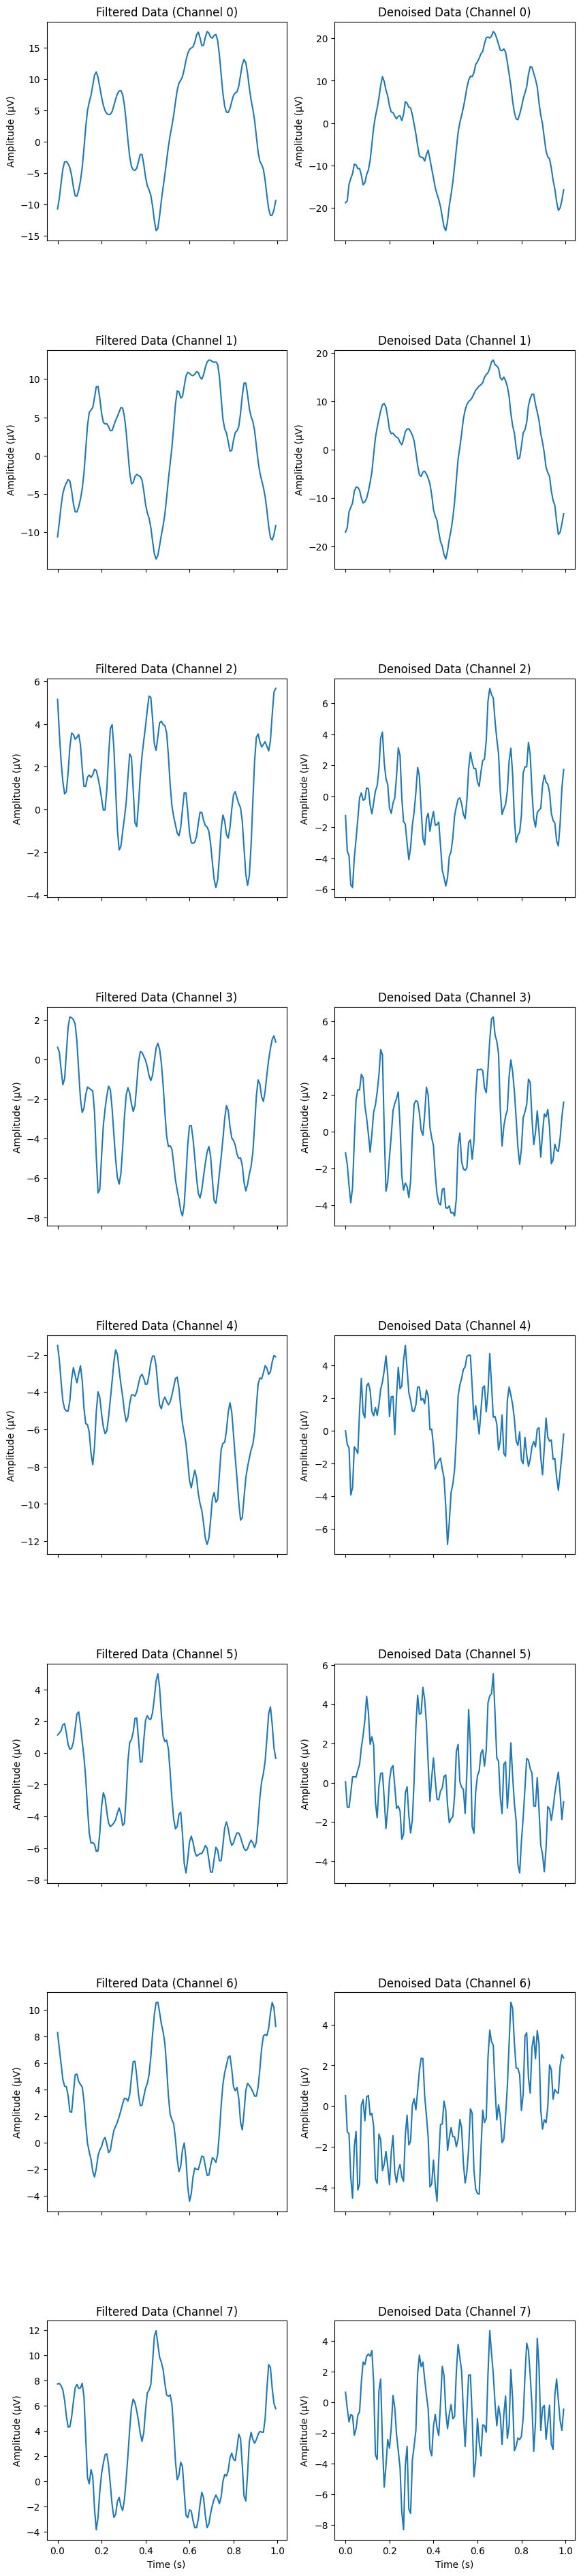

In [25]:
import numpy as np
import pandas as pd
from scipy import signal
from mne import create_info, EpochsArray
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Sampling rate
sampling_rate = 125

# Bandpass filter
low_cut = 0.5  # Low cutoff frequency (Hz)
high_cut = 30  # High cutoff frequency (Hz)
nyquist = sampling_rate / 2
low = low_cut / nyquist
high = high_cut / nyquist
order = 4  # Filter order
normalized_cutoff = [low, high]
filter_coefficients = signal.butter(order, normalized_cutoff, btype='band', output='ba')

# Notch filter
notch_freq = 50  # Notch frequency (Hz) to remove power line noise
notch_quality_factor = 30  # Quality factor for the notch filter
notch_filter = signal.iirnotch(notch_freq, notch_quality_factor, sampling_rate)

# Apply filters and save filtered data to a new DataFrame
filtered_df = denoised_df.copy()
for col in filtered_df.columns:
    filtered_df[col] = signal.filtfilt(*filter_coefficients, filtered_df[col])
    filtered_df[col] = signal.filtfilt(*notch_filter, filtered_df[col])

# Re-reference to average
filtered_df = filtered_df.sub(filtered_df.mean(axis=1), axis=0)

# Baseline correction
baseline_start = 0  # Start time (in seconds) for baseline
baseline_end = 1  # End time (in seconds) for baseline
baseline_samples = slice(int(baseline_start * sampling_rate), int(baseline_end * sampling_rate))
baseline_mean = filtered_df.iloc[baseline_samples].mean()
filtered_df = filtered_df.sub(baseline_mean, axis=1)

# Imagined speech epoch extraction
epoch_duration = 1  # Duration of each epoch in seconds
epoch_start_time = 3  # Start time of epoch extraction in seconds
epoch_end_time = 10  # End time of epoch extraction in seconds
epoch_samples_per_epoch = int(epoch_duration * sampling_rate)

epochs_data_filtered = []
epochs_data_denoised = []

for i in range(len(filtered_df) // epoch_samples_per_epoch):
    epoch_data_filtered = filtered_df.iloc[i * epoch_samples_per_epoch : (i + 1) * epoch_samples_per_epoch].values.T
    epochs_data_filtered.append(epoch_data_filtered)

    # Assuming denoised_data is available with the same shape as filtered_data
    epoch_data_denoised = denoised_df.iloc[i * epoch_samples_per_epoch : (i + 1) * epoch_samples_per_epoch].values.T
    epochs_data_denoised.append(epoch_data_denoised)

# Create MNE info object
n_channels = len(filtered_df.columns)
ch_names = filtered_df.columns.tolist()
ch_types = ['eeg'] * n_channels
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sampling_rate)

# Create MNE EpochsArray for filtered data
epochs_filtered = EpochsArray(epochs_data_filtered, info)

# Create MNE EpochsArray for denoised data
epochs_denoised = EpochsArray(epochs_data_denoised, info)

# Plotting all channels
num_channels = len(epochs_filtered.ch_names)
fig, axs = plt.subplots(num_channels, 2, figsize=(10, 6*num_channels), sharex=True)

for i in range(num_channels):
    axs[i, 0].plot(epochs_filtered.times, epochs_filtered.get_data()[:, i, :].mean(axis=0))
    axs[i, 0].set_title(f'Filtered Data (Channel {i})')
    axs[i, 0].set_ylabel('Amplitude (μV)')

    axs[i, 1].plot(epochs_denoised.times, epochs_denoised.get_data()[:, i, :].mean(axis=0))
    axs[i, 1].set_title(f'Denoised Data (Channel {i})')
    axs[i, 1].set_ylabel('Amplitude (μV)')

# Set x-axis label only for the last subplot
axs[-1, 0].set_xlabel('Time (s)')
axs[-1, 1].set_xlabel('Time (s)')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()


In [26]:
# Calculate mean of filtered EEG data for each channel
mean_data = filtered_df.mean()

# Create a new DataFrame to store the mean data
mean_df = pd.DataFrame(mean_data, columns=['Mean Amplitude (μV)'])

# Display the new DataFrame
print(mean_df)


               Mean Amplitude (μV)
EXG Channel 0             3.130392
EXG Channel 1             1.704684
EXG Channel 2             1.436045
EXG Channel 3            -2.665953
EXG Channel 4            -6.074102
EXG Channel 5            -2.525612
EXG Channel 6             2.503132
EXG Channel 7             2.491415


In [27]:
filtered_df.to_csv("filtered_data.csv", index=False)


In [28]:
denoised_df

EXG Channel 0  EXG Channel 1  EXG Channel 2  EXG Channel 3  \
0     -2.022153e-12   7.069738e-13  -1.024736e-12   8.092527e-14   
1     -6.080439e+01  -4.176556e+01  -4.557597e+01  -2.764327e+00   
2     -3.184793e+01  -2.142974e+01  -2.612443e+01  -7.652245e-01   
3     -3.261333e+01  -2.315852e+01  -2.769458e+01   7.391212e-01   
4     -4.997331e+01  -3.480584e+01  -3.815961e+01  -1.382825e+00   
...             ...            ...            ...            ...   
2409  -3.277956e+01  -4.003665e+00  -9.136105e+00  -2.734889e-01   
2410  -2.217153e+01   1.074096e+00  -7.839344e+00  -1.826173e+00   
2411  -2.455847e+01  -3.873227e+00  -8.652809e+00  -4.089382e+00   
2412  -4.345001e+01  -1.542014e+01  -1.544825e+01  -2.942293e+00   
2413  -1.130421e-12   1.064806e-14   8.041789e-12  -3.545517e-14   

      EXG Channel 4  EXG Channel 5  EXG Channel 6  EXG Channel 7  
0      7.728306e-12   5.853729e-12   8.183007e-12   3.947956e-12  
1     -2.579962e+01  -2.716901e+01  -2.681377e+01  -1.288942e+01  
2     -1.167535e+01  -9.749875e+00  -2.208255e+01  -1.212742e+01  
3     -8.053657e+00  -8.706252e+00  -2.824713e+01  -1.802100e+01  
4     -1.790793e+01  -1.769363e+01  -3.946156e+01  -2.894343e+01  
...             ...            ...            ...            ...  
2409  -1.255393e+02  -1.971245e+01  -7.153197e+01  -7.826045e+01  
2410  -8.079402e+01  -1.524940e+01  -3.402797e+01  -5.576548e+01  
2411  -8.320656e+01  -2.243937e+01  -3.487060e+01  -5.262389e+01  
2412  -1.739409e+02  -3.772326e+01  -7.747162e+01  -7.501919e+01  
2413  -9.403678e-13  -1.479059e-12  -2.674103e-12   3.784494e-12  

[2414 rows x 8 columns]

In [29]:
filtered_df

EXG Channel 0  EXG Channel 1  EXG Channel 2  EXG Channel 3  \
0          0.073578       1.155616       3.434634      -3.268943   
1        -18.015836      -5.229748      -6.722564      13.846662   
2        -22.320966      -6.759524      -9.601407      20.152856   
3        -17.282339      -4.728667      -6.681971      18.435401   
4        -14.219537      -2.551997      -3.826458      17.125874   
...             ...            ...            ...            ...   
2409      -2.440960      20.083396      28.887634      25.165664   
2410      -2.991750      22.070728      28.080428      27.389667   
2411      -1.979685      24.965899      34.154089      35.761290   
2412      -3.951957      15.802394      29.303935      29.345851   
2413     -11.008790      -9.853410       5.802449      -0.475003   

      EXG Channel 4  EXG Channel 5  EXG Channel 6  EXG Channel 7  
0         -4.608731      -4.027768       1.503729       5.737884  
1         -2.109890      -0.356194       2.096095      16.491476  
2          1.436062       2.703931      -1.886189      16.275238  
3          4.061931       4.920419      -6.525450       7.800675  
4          2.789903       6.822410      -8.003266       1.863072  
...             ...            ...            ...            ...  
2409     -50.954003      21.459172     -18.365819     -23.835085  
2410     -63.687788      18.821743      -8.196106     -21.486923  
2411     -85.428594      18.204010      -8.671798     -17.005211  
2412     -70.351629      14.443084      -7.557393      -7.034284  
2413      -1.753309       5.706292       3.136352       8.445420  

[2414 rows x 8 columns]

Creating RawArray with float64 data, n_channels=8, n_times=2414
    Range : 0 ... 2413 =      0.000 ...    19.304 secs
Ready.


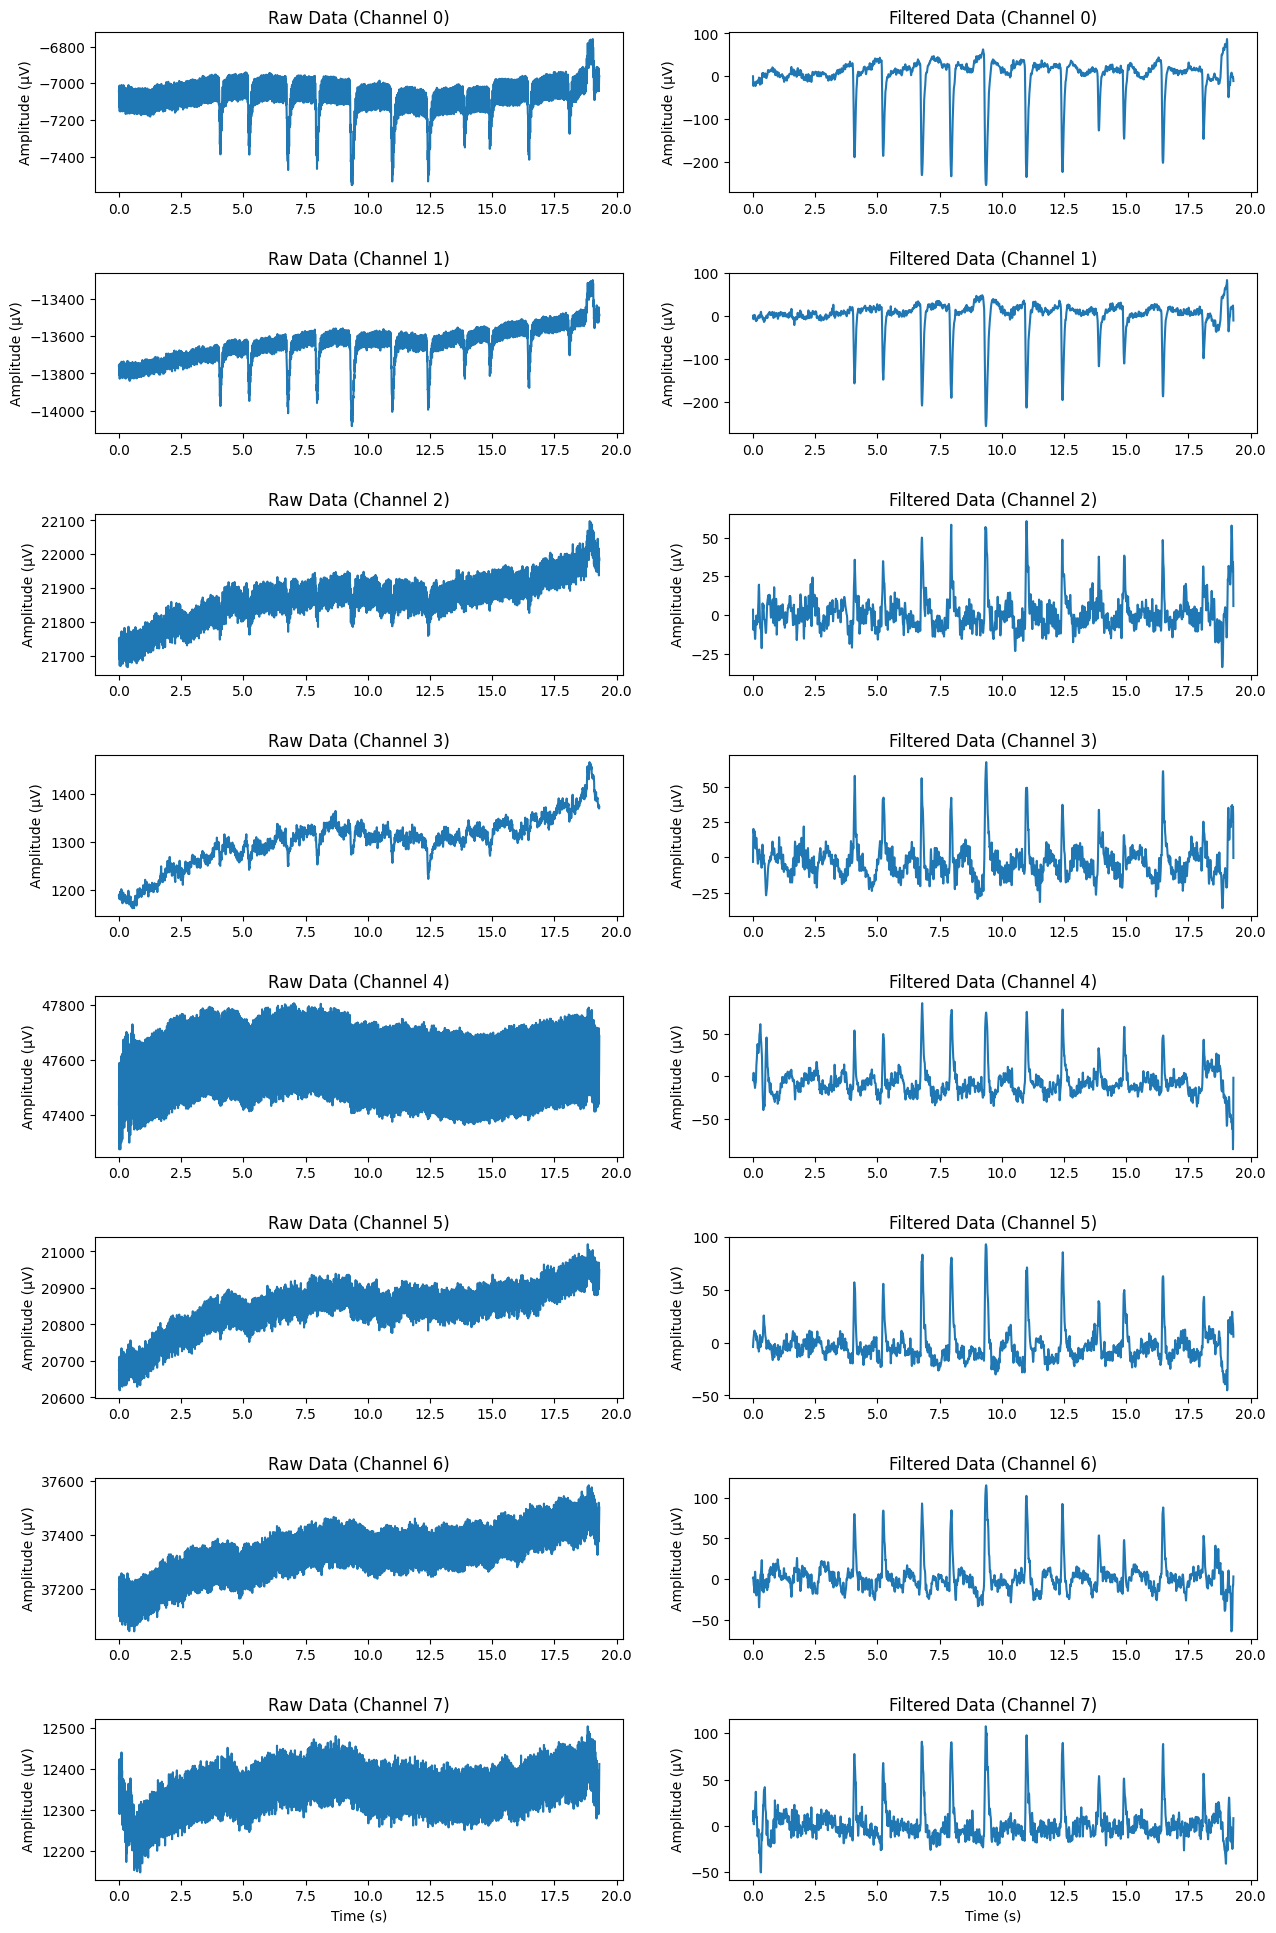

In [37]:
# Загрузка и создание объекта `raw`
data_ica_df = df.iloc[:, 1:9]
sfreq = 125
info = mne.create_info(ch_names=data_ica_df.columns.tolist(), sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(data_ica_df.T.values, info)

# Теперь raw_df содержит исходные данные
raw_df = pd.DataFrame(data=raw.get_data().T, columns=data_ica_df.columns.tolist())

# Количество каналов
n_channels = len(raw_df.columns)
fig, axs = plt.subplots(n_channels, 2, figsize=(15, 3 * n_channels))

for i, channel in enumerate(raw_df.columns):
    # Исходный сигнал (raw)
    axs[i, 0].plot(raw_df.index / sampling_rate, raw_df[channel])
    axs[i, 0].set_title(f'Raw Data (Channel {i})')
    axs[i, 0].set_ylabel('Amplitude (µV)')
    if i == n_channels - 1:
        axs[i, 0].set_xlabel('Time (s)')

    # Фильтрованный сигнал (filtered)
    axs[i, 1].plot(filtered_df.index / sampling_rate, filtered_df[channel])
    axs[i, 1].set_title(f'Filtered Data (Channel {i})')
    axs[i, 1].set_ylabel('Amplitude (µV)')
    if i == n_channels - 1:
        axs[i, 1].set_xlabel('Time (s)')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Отображаем график
plt.show()

Creating RawArray with float64 data, n_channels=8, n_times=2414
    Range : 0 ... 2413 =      0.000 ...    19.304 secs
Ready.
Using EOG channel: EXG Channel 0
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG Channel 0 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1250 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 13 significant peaks
Number of EOG events detected: 13
Not setting metadata
13 matching events found
No baseline corre

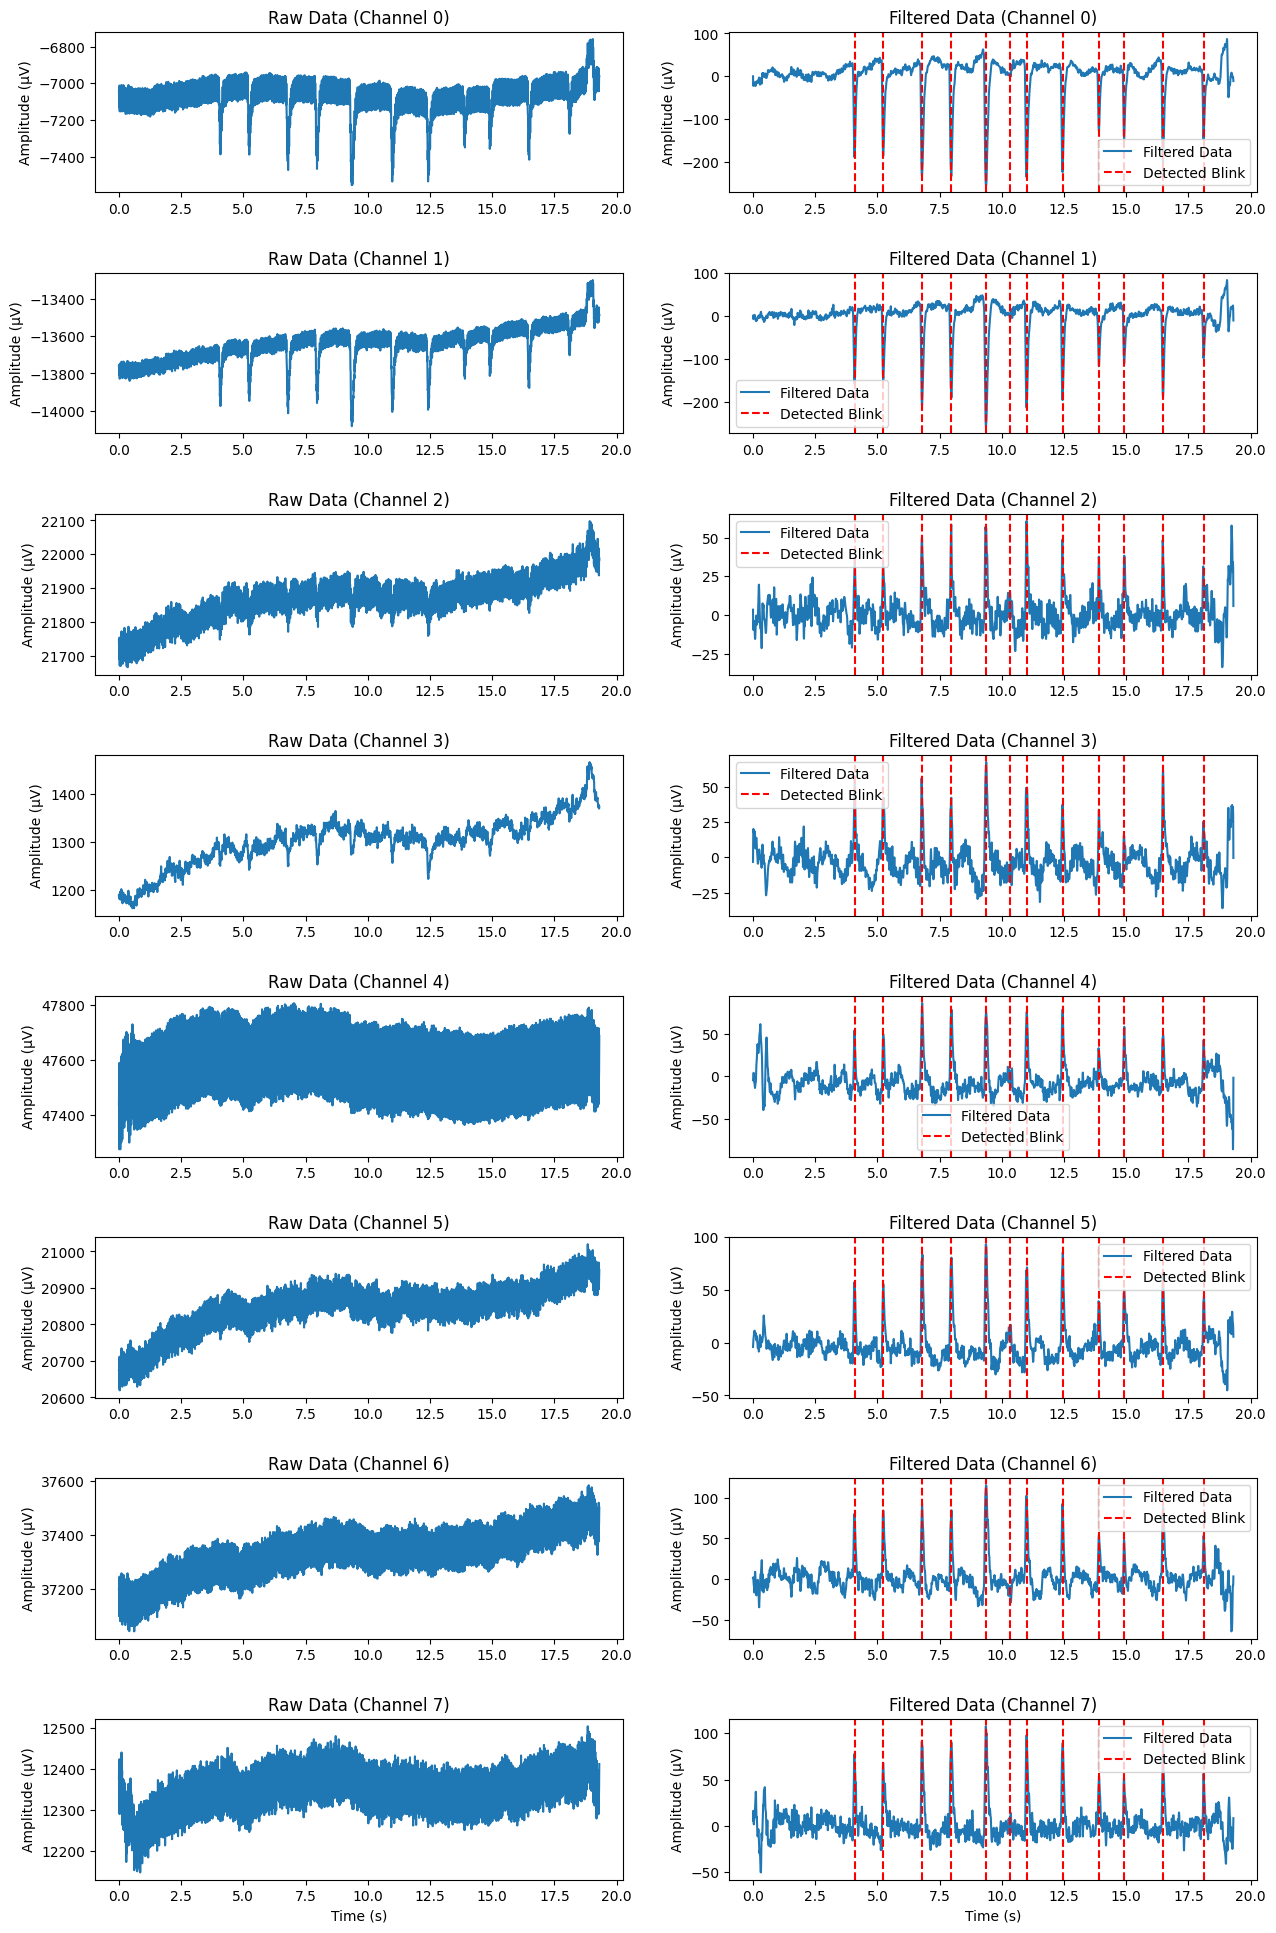

    sample  prev_event_id  event_id
0      510              0       998
1      655              0       998
2      849              0       998
3      996              0       998
4     1170              0       998
5     1289              0       998
6     1374              0       998
7     1555              0       998
8     1738              0       998
9     1865              0       998
10    2060              0       998
11    2264              0       998


In [39]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Предполагаем, что отфильтрованные данные загружены в объект RawArray
filtered_data = filtered_df.T.values * 1e-6  # конвертация в вольты, если данные в микровольтах
info = mne.create_info(ch_names=filtered_df.columns.tolist(), sfreq=sampling_rate, ch_types=['eeg']*n_channels)
raw_filtered = mne.io.RawArray(filtered_data, info)

# Создание EOG каналов из одного из уже существующих каналов (например, первый канал)
raw_filtered.set_channel_types({channel: 'eog' for channel in filtered_df.columns[0:1]})

# Создание EOG epochs для обнаружения морганий
eog_epochs = mne.preprocessing.create_eog_epochs(raw_filtered, ch_name=filtered_df.columns[0])
eog_events = eog_epochs.events

# Печать и создание DataFrame для событий
print(eog_events)
eog_events_df = pd.DataFrame(eog_events, columns=['sample', 'prev_event_id', 'event_id'])

# Графики сигналов и отмеченных EOG событий
fig, axs = plt.subplots(n_channels, 2, figsize=(15, 3 * n_channels))

for i, channel in enumerate(filtered_df.columns):
    # Исходный сигнал (raw)
    axs[i, 0].plot(raw_df.index / sampling_rate, raw_df[channel], label='Raw Data')
    axs[i, 0].set_title(f'Raw Data (Channel {i})')
    axs[i, 0].set_ylabel('Amplitude (µV)')
    if i == n_channels - 1:
        axs[i, 0].set_xlabel('Time (s)')

    # Фильтрованный сигнал (filtered)
    axs[i, 1].plot(filtered_df.index / sampling_rate, filtered_df[channel], label='Filtered Data')
    
    # Отметим события на графиках
    blink_samples = eog_events_df['sample'].values
    blink_times = blink_samples / sampling_rate
    for blink_time in blink_times:
        axs[i, 1].axvline(x=blink_time, color='r', linestyle='--', label='Detected Blink' if blink_time == blink_times[0] else "")
    
    axs[i, 1].set_title(f'Filtered Data (Channel {i})')
    axs[i, 1].set_ylabel('Amplitude (µV)')
    if i == n_channels - 1:
        axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].legend()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Отображаем график с отмеченными событиями
plt.show()

print(eog_events_df)